In [199]:
import re

import matplotlib.pyplot as plt
import numpy as np
import torch

In [24]:
import nltk

from nltk.corpus import webtext
# from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize

In [203]:
DEVICE = "cuda:0"

In [172]:
def text_cleaning(text):
    text = re.sub('-\n', '', text)
    text = re.sub(r"""[*#@&%£ö'ä$ü¨~^)('+°¢./><$\[\]`]""", '', text)
    text = re.sub('[0-9]', '', text)
    return re.sub('\n', ' ', text)

In [183]:
txt = webtext.raw('overheard.txt')
sentences = sent_tokenize(txt)
sentences = [re.sub(r".*: ", '', sent, 1) for sent in sentences]
sentences = [text_cleaning(sentence) for sentence in sentences]
sentences = [[w.lower() for w in nltk.word_tokenize(sentence)] for sentence in sentences]

In [218]:
vocab = {}
for tokens in sentences:
    for token in tokens:
        if token in vocab.keys():
            vocab[token] += 1
        else:
            vocab[token] = 1
        
vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: -item[1])}
W = len(vocab)
print("vocabulary size : " + str(W))

word_to_idx = {k : (i+1) for i,(k,_) in enumerate(vocab.items())}
word_to_idx['ukn'] = 0
idx_to_word = {v : k for k, v in word_to_idx.items()}

vocabulary size : 9913


In [194]:
val_split = 0.2
test_split = 0.1

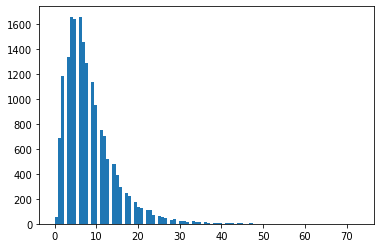

In [202]:
plt.hist([len(sent) for sent in sentences], bins = 100)
plt.show()

In [12]:
torch.manual_seed(0)
assert torch.cuda.is_available()

In [259]:
class LM_dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        sentences,
        word_to_idx
    ):
        self.word_to_idx = word_to_idx
        self.indices = [[self.get_idx(w) for w in sentence] for sentence in sentences if len(sentence) > 1]
        
    def get_idx(self, token):
        try:
            return self.word_to_idx[token]
        except KeyError:
            return self.word_to_idx['ukn']
        
    def __getitem__(self, idx):
        indices = self.indices[idx]
        if len(indices) > 16:
            indices = indices[:16]
        
        return torch.LongTensor(indices[:-1]).to(DEVICE), torch.LongTensor([indices[-1]]).to(DEVICE)
        
    def __len__(self):
        return len(self.indices)

In [260]:
train_dataset = LM_dataset(
    sentences,
    word_to_idx
)

In [261]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle = True,
    pin_memory = True
)

In [263]:
emb_layer = torch.nn.Embedding(
    W,
    32
).to(DEVICE)

In [266]:
emb_layer(train_dataset[0][1])

tensor([[ 0.2770,  0.0610,  1.2657, -0.2553,  0.0860, -2.1803,  0.7664,  1.2670,
          0.5533,  0.9116,  1.5263, -0.2382,  0.0528,  0.0142,  0.9663,  0.3252,
          0.6737,  1.0633, -1.0792, -1.4437, -1.8834,  1.8310, -1.2397,  0.6616,
         -1.8963, -0.2500, -0.3420, -0.9200, -0.1088, -0.2085, -0.2730,  1.2509]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)

In [125]:
class NextWordPredictor(torch.nn.Module):
    # inspired from https://github.com/pytorch/examples/blob/master/word_language_model/model.py
    def __init__(
        self,
        num_tokens : int,
        emb_dim : int,
        num_hidden_layers : int,
        hidden_layer_size : int,
        dropout : float,
        non_linearity : str,
        tie_weights : bool = False
    ):
        super(NextWordPredictor, self).__init__()
        self.num_tokens = num_tokens
        
        self.drop = torch.nn.Dropout(dropout)
        self.encoder = torch.nn.Embedding(
            num_tokens,
            emb_dim
        )
        self.rnn = torch.nn.RNN(
            emb_dim,
            hidden_layer_size,
            nonlinearity = non_linearity,
            dropout = dropout
        )
        self.decoder = torch.nn.Linear(hidden_layer_size, num_tokens)
        
        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016) -> https://arxiv.org/abs/1608.05859
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016) -> https://arxiv.org/abs/1611.01462
        if tie_weights:
            if nhid != ninp:
                raise ValueError('When using the tied flag, nhid must be equal to emsize')
            self.decoder.weight = self.encoder.weight
        
        self.init_weights()
        
    def init_weights(self):
        torch.nn.init.normal_(self.encoder.weight, mean = 0, std = 1)
        torch.nn.init.normal_(self.decoder.weight, mean = 0, std = 1)

    def forward(self, input_, hidden):
        embebbing = self.drop(self.encoder(input_))
        output, hidden = self.rnn(embedding, hidden)
        output = self.drop(output)
        decoded = self.decoder(output)
        decoded.view(-1, self.num_tokens)
        return F.log_softmax(decoded, dim = 1), hidden

In [126]:
model = NextWordPredictor(
    num_tokens = len(vocab),
    emb_dim = 64,
    num_hidden_layers = 1,
    hidden_layer_size = 64,
    dropout = 0.2,
    non_linearity = 'relu',
    tie_weights = False
)

In [128]:
model

NextWordPredictor(
  (drop): Dropout(p=0.2, inplace=False)
  (encoder): Embedding(4620, 64)
  (rnn): RNN(64, 64, dropout=0.2)
  (decoder): Linear(in_features=64, out_features=4620, bias=True)
)